In [1]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("bmh")

import numpy as np
from scipy.stats import binom
from DP.utils import (
    binom_derivative,
    binom_optimal_privacy,
    fisher_gradient,
    fisher_information_privatized,
    fisher_information_binom
)
from DP.linear_solver import LinearSolver
from DP.pga_with_edge_traversal import PGAWithEdgeTraversal
from DP.scipy_solver import ScipySolver
from matplotlib.patches import FancyArrowPatch
from DP.DP_tester import DP_tester
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from DP.pga_with_edge_traversal import PGAETMultipleRestarts
from tqdm import tqdm

## Feasible set

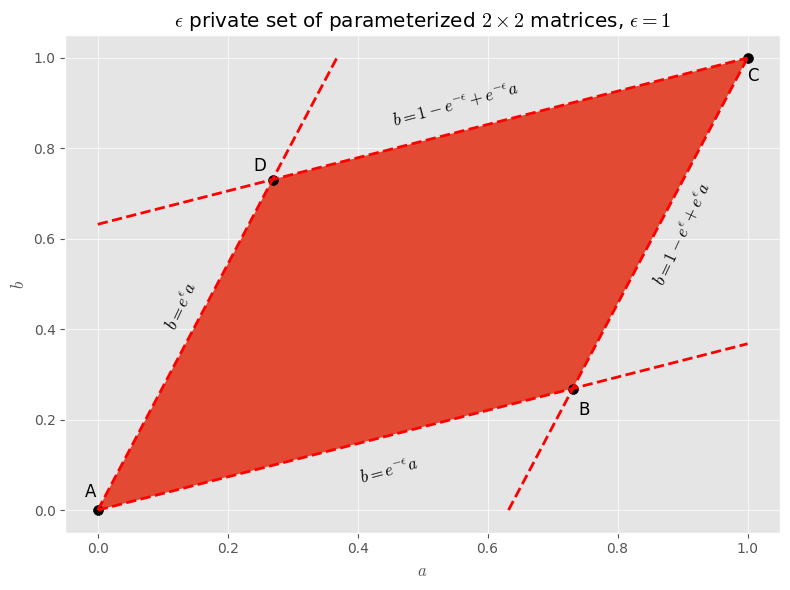

In [2]:
EPSILON = 1

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot([0, np.exp(-EPSILON)], [0, 1], color="red", linestyle="dashed")
ax.plot([0, 1], [0, np.exp(-EPSILON)], color="red", linestyle="dashed")

ax.plot([0, 1], [1 - np.exp(-EPSILON), 1], color="red", linestyle="dashed")
ax.plot([1 - np.exp(-EPSILON), 1], [0, 1], color="red", linestyle="dashed")

ax.fill_between(
    x=[0, (1 - np.exp(-EPSILON)) / (np.exp(EPSILON) - np.exp(-EPSILON)), (1 - np.exp(EPSILON)) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1], 
    y1=[0, (np.exp(EPSILON) - 1) / (np.exp(EPSILON) - np.exp(-EPSILON)), 1 - np.exp(-EPSILON) + (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    y2=[0, (1 - np.exp(-EPSILON)) / (np.exp(2*EPSILON) - 1), (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1]
)

ax.scatter([0, (1-np.exp(EPSILON)) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1, (1-np.exp(-EPSILON)) / (np.exp(EPSILON) - np.exp(-EPSILON))],
           [0, (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1, (np.exp(EPSILON) - 1) / (np.exp(EPSILON) - np.exp(-EPSILON))],
           s=50, color="black")

ax.annotate(r"$b = e^\epsilon a$", xy=(0.10, 0.4), fontsize="large", rotation=65)
ax.annotate(r"$b = e^{-\epsilon} a$", xy=(0.4, 0.06), fontsize="large", rotation=15)
ax.annotate(r"$b = 1 - e^{-\epsilon} + e^{-\epsilon}a$", xy=(0.45, 0.85), fontsize="large", rotation=15)
ax.annotate(r"$b = 1 - e^\epsilon + e^\epsilon a$", xy=(0.85, 0.5), fontsize="large", rotation=65)

ax.annotate("A", xy=(-0.02, 0.03), fontsize="large")
ax.annotate("B", xy=(0.74, 0.21), fontsize="large")
ax.annotate("C", xy=(1, 0.95), fontsize="large")
ax.annotate("D", xy=(0.24, 0.75), fontsize="large")

ax.set_xlabel("$a$")
ax.set_ylabel("$b$")
ax.set_title(r"$\epsilon$ private set of parameterized $2\times 2$ matrices, $\epsilon=1$")

plt.tight_layout()
plt.savefig("figures/epsilon_private_set.png")
plt.show()

## Objective function with gradient

/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:104: RuntimeWarning: invalid value encountered in divide
  2 * np.outer(p_theta_dot, Q_ptheta_dot) / Q_ptheta
/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:105: RuntimeWarning: invalid value encountered in divide
  - np.outer(p_theta, Q_ptheta_dot_squared) / Q_ptheta_squared


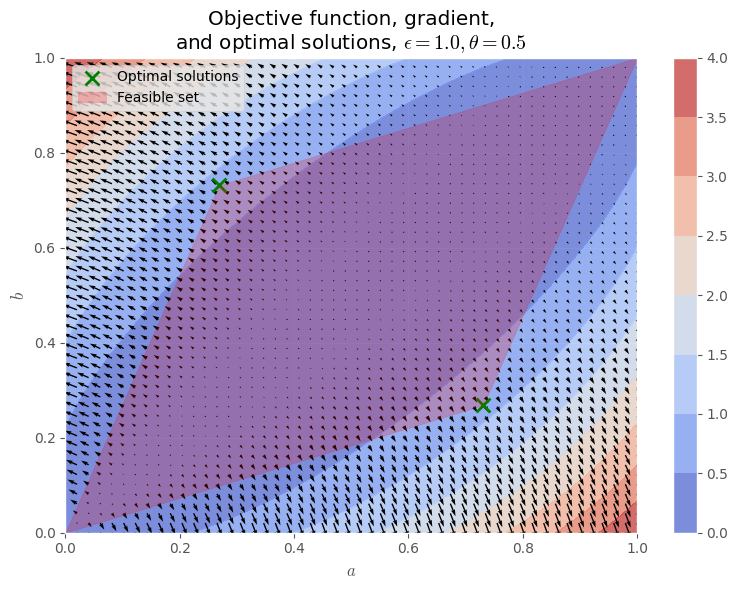

In [3]:
N = 1
THETA = 0.5
EPSILON = 1.0
NVALS = 50

p_theta = binom.pmf(np.arange(N + 1), N, THETA)
p_theta_dot = np.array([binom_derivative(i, N, THETA) for i in range(N + 1)])

a_vals = np.linspace(0, 1, NVALS)
b_vals = np.linspace(0, 1, NVALS)

grads_a = list()
grads_b = list()
fishers = list()

for a in a_vals:
    for b in b_vals:
        q_mat = np.array([[a, b], [1-a, 1-b]])
        grad = fisher_gradient(p_theta, p_theta_dot, q_mat)

        fishers.append(fisher_information_privatized(q_mat, p_theta, p_theta_dot))

        grads_a.append(grad[0, 0])
        grads_b.append(grad[0, 1])

grads_a = np.array(grads_a).reshape((NVALS, NVALS), order="F")
grads_b = np.array(grads_b).reshape((NVALS, NVALS), order="F")
fishers = np.array(fishers).reshape((NVALS, NVALS), order="F")

opt_solutions, _, _, _ = binom_optimal_privacy(LinearSolver(), N, EPSILON, THETA)
xs = opt_solutions[:, 0]
ys = opt_solutions[:, 1]

# Feasible area plot
fig, ax = plt.subplots(figsize=(8, 6))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.7)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)

ax.fill_between(
    x=[0, (1 - np.exp(-EPSILON)) / (np.exp(EPSILON) - np.exp(-EPSILON)), (1 - np.exp(EPSILON)) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1], 
    y1=[0, (np.exp(EPSILON) - 1) / (np.exp(EPSILON) - np.exp(-EPSILON)), 1 - np.exp(-EPSILON) + (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    y2=[0, (1 - np.exp(-EPSILON)) / (np.exp(2*EPSILON) - 1), (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    label="Feasible set",
    color="red",
    alpha=0.2
)

plt.legend()
plt.title("Objective function, gradient,\n" + fr"and optimal solutions, $\epsilon = {EPSILON}, \theta = {THETA}$")
plt.tight_layout()
plt.savefig("figures/objective_function_gradient.png")
plt.show()

In [8]:
opt_solutions

array([[0.26894142, 0.73105858],
       [0.73105858, 0.26894142]])

In [16]:
from DP.utils import is_epsilon_private, epsilon_privacy_violation
a = 0.731
b = 0.268
q = np.array([[a, b], [1 - a, 1 - b]])
print(is_epsilon_private(q, 1, tol=1e-2))
print(epsilon_privacy_violation(q, 1))

True
0.002500469972975816


## Everything PLUS gradient ascent path

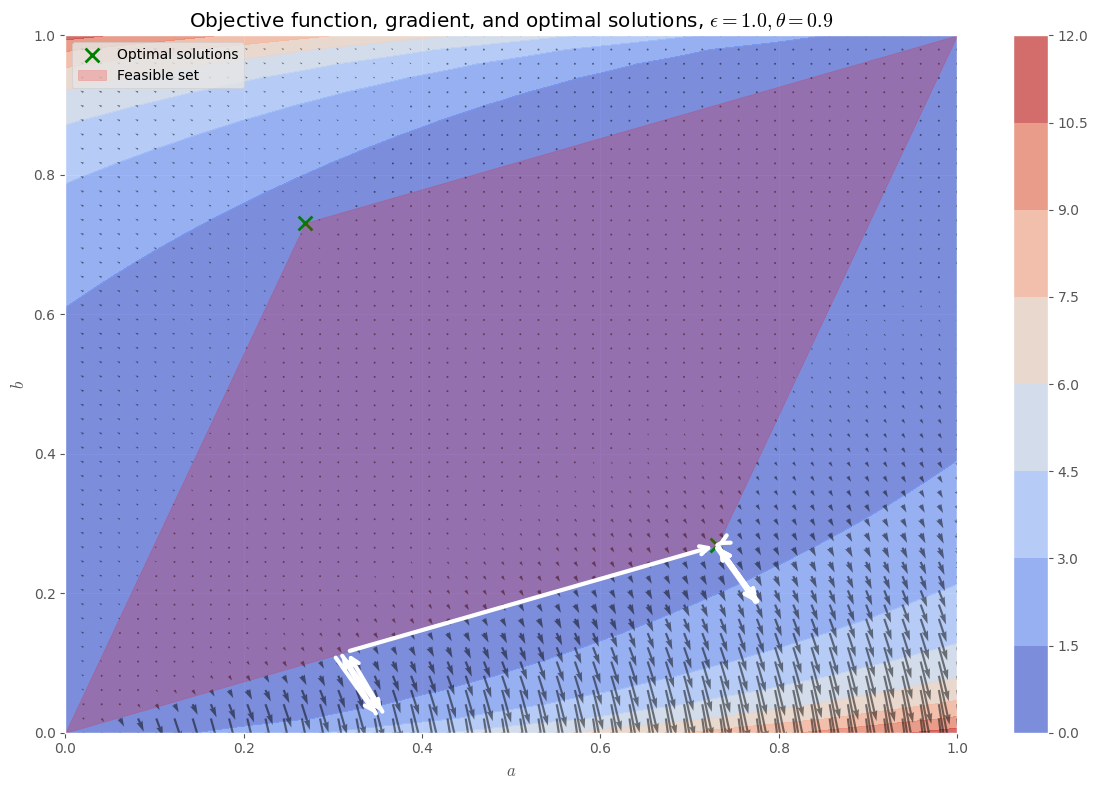

In [22]:
N = 1
THETA = 0.9
EPSILON = 1.0

p_theta = binom.pmf(np.arange(N + 1), N, THETA)
p_theta_dot = np.array([binom_derivative(i, N, THETA) for i in range(N + 1)])

a_vals = np.linspace(0, 1, NVALS)
b_vals = np.linspace(0, 1, NVALS)

grads_a = list()
grads_b = list()
fishers = list()

for a in a_vals:
    for b in b_vals:
        q_mat = np.array([[a, b], [1-a, 1-b]])
        grad = fisher_gradient(p_theta, p_theta_dot, q_mat)

        fishers.append(fisher_information_privatized(q_mat, p_theta, p_theta_dot))

        grads_a.append(grad[0, 0])
        grads_b.append(grad[0, 1])

grads_a = np.array(grads_a).reshape((NVALS, NVALS), order="F")
grads_b = np.array(grads_b).reshape((NVALS, NVALS), order="F")
fishers = np.array(fishers).reshape((NVALS, NVALS), order="F")

opt_solutions, _, _,_ = binom_optimal_privacy(LinearSolver(), N, EPSILON, THETA)
xs = opt_solutions[:, 0]
ys = opt_solutions[:, 1]

_, _, history, _ = binom_optimal_privacy(PGAWithEdgeTraversal(), N, EPSILON, THETA)
all_history = np.array(history)

#colors = plt.cm.binary(np.linspace(0, 1, len(all_history)))
fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.7)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, cmap="coolwarm", alpha=0.5)
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
ax.fill_between(
    x=[0, (1 - np.exp(-EPSILON)) / (np.exp(EPSILON) - np.exp(-EPSILON)), (1 - np.exp(EPSILON)) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1], 
    y1=[0, (np.exp(EPSILON) - 1) / (np.exp(EPSILON) - np.exp(-EPSILON)), 1 - np.exp(-EPSILON) + (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    y2=[0, (1 - np.exp(-EPSILON)) / (np.exp(2*EPSILON) - 1), (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    label="Feasible set",
    color="red",
    alpha=0.2
)
for i in range(len(all_history) - 1):
    arrow = FancyArrowPatch((all_history[i,0,0], all_history[i,0,1]), (all_history[i+1,0,0], all_history[i+1,0,1]), 
                             color="white", arrowstyle='->', mutation_scale=15, linewidth=3)
    ax.add_patch(arrow)
plt.legend()
plt.title(fr"Objective function, gradient, and optimal solutions, $\epsilon = {EPSILON}, \theta = {THETA}$")
plt.tight_layout()
plt.savefig("figures/sample_ascent_path")
plt.show()

### Runtimes

Calculating for Linear solver
Calculating for n=1
Calculating for n=2
Calculating for n=3
Calculating for n=4
Calculating for n=5
Calculating for n=6
Calculating for n=7
Calculating for n=8
Calculating for n=9
Calculating for n=10
Calculating for n=11
Calculating for n=12
Calculating for n=13
Calculating for n=14
Calculating for n=15
Calculating for PGAET
Calculating for n=1
Calculating for n=2
Calculating for n=3
Calculating for n=4
Calculating for n=5
Calculating for n=6
Calculating for n=7
Calculating for n=8
Calculating for n=9
Calculating for n=10
Calculating for n=11
Calculating for n=12
Calculating for n=13
Calculating for n=14
Calculating for n=15
Calculating for n=16
Calculating for n=17
Calculating for n=18
Calculating for n=19
Calculating for n=20
Calculating for n=21
Calculating for n=22
Calculating for n=23
Calculating for n=24
Calculating for n=25
Calculating for n=26
Calculating for n=27
Calculating for n=28
Calculating for n=29
Calculating for n=30


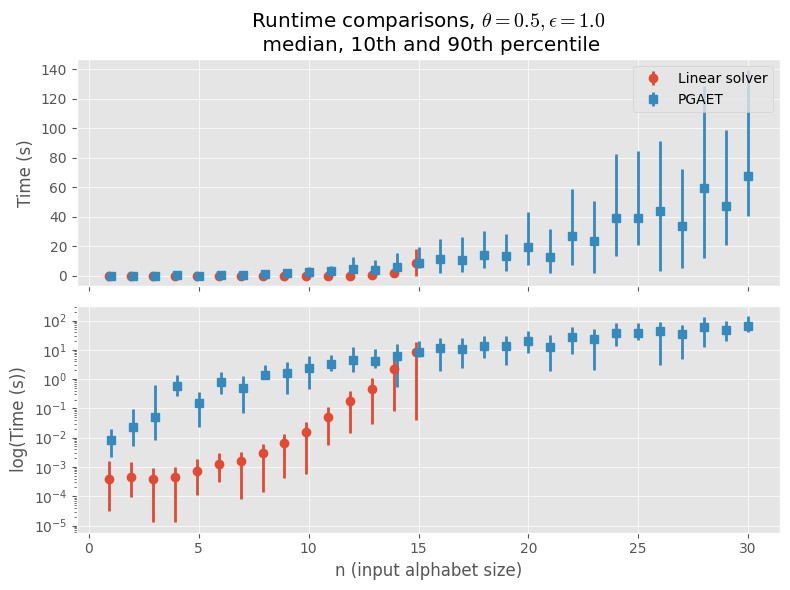

In [3]:
from time import time

def compare_runtimes(solvers, ns, theta, epsilon, log=False, n_restarts: int = 10):
    median_times = list()
    upper_quantile_90 = list()
    lower_quantile_10 = list()

    for i in range(len(solvers)):
        solver = solvers[i]
        print(f"Calculating for {solver.name}")
        solver_medians = list()
        solver_uppers = list()
        solver_downers = list()
        n_max = ns[i]
        for n in range(1, n_max + 1):
            print(f"Calculating for n={n}")
            times_for_n = list()
            for _ in range(n_restarts):
                t_start = time()
                _, _, _, _ = binom_optimal_privacy(solver, n, epsilon, theta)
                t_end = time()

                time_taken = t_end - t_start

                times_for_n.append(time_taken)
            median_time = np.median(times_for_n)
            q_90 = np.quantile(times_for_n, 0.9)
            q_10 = np.quantile(times_for_n, 0.1)
            solver_medians.append(median_time)
            solver_uppers.append(q_90)
            solver_downers.append(q_10)

        median_times.append(solver_medians)
        upper_quantile_90.append(solver_uppers)
        lower_quantile_10.append(solver_downers)

    fig, ax = plt.subplots(figsize=(8, 6), nrows=2, sharex=True)

    formats = ["o", "s", "x", "d", "v", "^", "<", ">"]
    for i in range(len(solvers)):
        ns_to_plot = np.arange(1, ns[i] + 1)
        ax[0].errorbar(ns_to_plot + (i-1) * 0.1,
                       median_times[i], 
                       yerr=[lower_quantile_10[i], upper_quantile_90[i]], 
                       label=solvers[i].name, fmt=formats[i])
    ax[0].set_ylabel("Time (s)")
    ax[0].set_title(rf"Runtime comparisons, $\theta={theta}, \epsilon={epsilon}$" + "\n median, 10th and 90th percentile")
    ax[0].legend()

    for i in range(len(solvers)):
        ns_to_plot = np.arange(1, ns[i] + 1)
        ax[1].errorbar(ns_to_plot + (i-1) * 0.1,
                       median_times[i],
                       yerr=[lower_quantile_10[i], upper_quantile_90[i]],
                       label=solvers[i].name, fmt=formats[i])
    ax[1].set_xlabel("n (input alphabet size)")
    ax[1].set_ylabel("log(Time (s))")
    ax[1].set_yscale("log")

    plt.tight_layout()
    plt.show()

compare_runtimes([LinearSolver(), PGAWithEdgeTraversal()], [15, 30], 0.5, 1.0, n_restarts=5)

### Cauchy bins

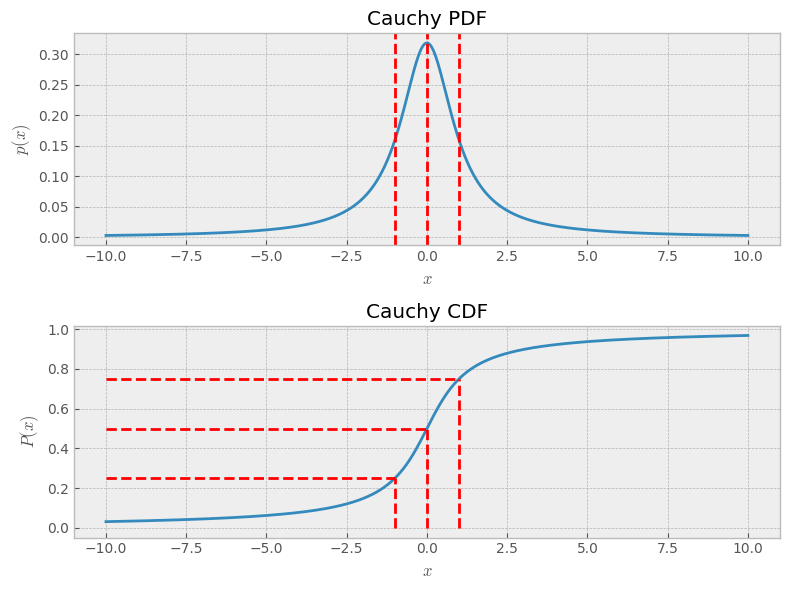

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("bmh")

# Utility functions for the Cauchy distribution
def cauchy_cumulative(x, theta):
    return np.arctan(x - theta) / np.pi + 0.5

def cauchy_quantile(p, theta):
    return np.tan(np.pi * (p - 0.5)) + theta

def cauchy_pdf(x, theta):
    return 1 / (np.pi * (1 + (x - theta)**2))

k = 4
theta = 0

bin_endpoints = [cauchy_quantile(i / k, theta) for i in range(k + 1)]
p_theta = np.array([
    cauchy_cumulative(bin_endpoints[i + 1], theta) - cauchy_cumulative(bin_endpoints[i], theta)
    for i in range(k)
])
p_theta_dot = np.array([
    cauchy_pdf(cauchy_quantile((i - 1) / k, theta), theta)
    - cauchy_pdf(cauchy_quantile(i / k, theta), theta)
    for i in range(1, k+1)
])

fig, ax = plt.subplots(figsize=(8, 6), nrows=2)

ax[0].plot(np.linspace(-10, 10, 1000), cauchy_pdf(np.linspace(-10, 10, 1000), theta))
ax[0].set_title("Cauchy PDF")
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$p(x)$")
for endpoint in bin_endpoints[1:-1]:
    ax[0].axvline(endpoint, color="red", linestyle="dashed")

ax[1].plot(np.linspace(-10, 10, 1000), cauchy_cumulative(np.linspace(-10, 10, 1000), theta))
ax[1].set_title("Cauchy CDF")
ax[1].set_xlabel("$x$")
ax[1].set_ylabel("$P(x)$")
for endpoint in bin_endpoints[1:-1]:
    ax[1].plot([endpoint, endpoint], [0, cauchy_cumulative(endpoint, theta)], color="red", linestyle="dashed")
    ax[1].plot([-10, endpoint], [cauchy_cumulative(endpoint, theta), cauchy_cumulative(endpoint, theta)], color="red", linestyle="dashed")

plt.tight_layout()
plt.show()

### Poisson approximation to the binomial

Binomial distribution is
$$f_B(k, n, p) = {n\choose k} p^k (1-p)^{n-k},$$
while the Poisson is
$$f_P(k, \lambda) = \frac{e^{-\lambda} \lambda^k}{k!}.$$
For $n$ sufficiently large, and $p$ sufficiently small, we can approximate one distribution with the other one
$$f_B(k; n, p) \approx f_P(k, \lambda = np).$$
The Poisson is a good approximation of the binomial if $n$ is at least $20$ and $p$ is smaller than $0.05$, and excellent approximation if $n \geq 100$ and $np \leq 10$.

Fisher information of the Poisson distribution is
$$ I_P(\lambda) = \frac{1}{\lambda},$$
while for the binomial $Binom(n, \frac{\lambda}{n})$ with respect again to $\lambda$ is
$$ I_B(\lambda) = \frac{1}{\lambda} + \frac{1}{n} + \frac{\lambda}{n(n-\lambda)}.$$
We can see that in the limit $n\to\infty$ we recover the original fisher information of the Poisson distribution
$$\lim_{n\to\infty} I_B(\lambda) = I_P(\lambda). $$
The reverse calculation probably gives the same result.

We need to make a slight modification to the $\dot{p_\theta}$ parameter, as additional $1/n$ factors come into play.
$$\frac{\partial}{\partial \lambda} f_B = \left( \frac{k}{\lambda} - \frac{n-k}{n-\lambda} \right) f_B(k, n, \frac{\lambda}{n}).$$

In [5]:
from DP.pga_with_edge_traversal import PGAETMultipleRestarts
from scipy.stats import binom

ns = [i + 2 for i in range(40)]
pga_best_fishes = list()
linear_fisher = list()
EPSILON = 0.5
LAMBDA = 1

pgaet = PGAETMultipleRestarts(n_restarts=5)
lp = LinearSolver()
for n in ns:
    print(f"Calculating for n = {n}.")
    k = n + 1
    p_theta = binom.pmf(np.arange(k), n, LAMBDA / n)
    p_theta_dot = [(i/LAMBDA - (n-i)/(n-LAMBDA))*binom.pmf(i, n, LAMBDA / n) for i in range(k)]
    
    result = pgaet(p_theta, p_theta_dot, EPSILON, k)
    opt_q = result["Q_matrix"]
    best_fish = fisher_information_privatized(opt_q, p_theta, p_theta_dot)
    pga_best_fishes.append(best_fish)
    if n <= 15:
        result = lp(p_theta, p_theta_dot, EPSILON, k)
        opt_q = result["Q_matrix"]
        best_fish = fisher_information_privatized(opt_q, p_theta, p_theta_dot)
        linear_fisher.append(best_fish)

Calculating for n = 2.
Epsilon privacy violation: 1.9533791627557306e-06
Calculating for n = 3.
Epsilon privacy violation: 2.4447233126778656e-10
Calculating for n = 4.
Epsilon privacy violation: 7.296118846866761e-07
Calculating for n = 5.
Epsilon privacy violation: 1.5766618407020427e-05
Calculating for n = 6.
Epsilon privacy violation: 2.903622660976879e-06
Calculating for n = 7.
Epsilon privacy violation: 1.971005462388098e-05
Calculating for n = 8.
Epsilon privacy violation: 1.7705993139008336e-05
Calculating for n = 9.
Epsilon privacy violation: 7.628858511826708e-06
Calculating for n = 10.
Epsilon privacy violation: 3.1183617965252486e-05
Calculating for n = 11.
Epsilon privacy violation: 2.715495076731853e-05
Calculating for n = 12.
Epsilon privacy violation: 2.2359780925657047e-05
Calculating for n = 13.
Epsilon privacy violation: 3.4926562697545904e-06
Calculating for n = 14.
Epsilon privacy violation: 3.0243765509418985e-05
Calculating for n = 15.
Epsilon privacy violation: 

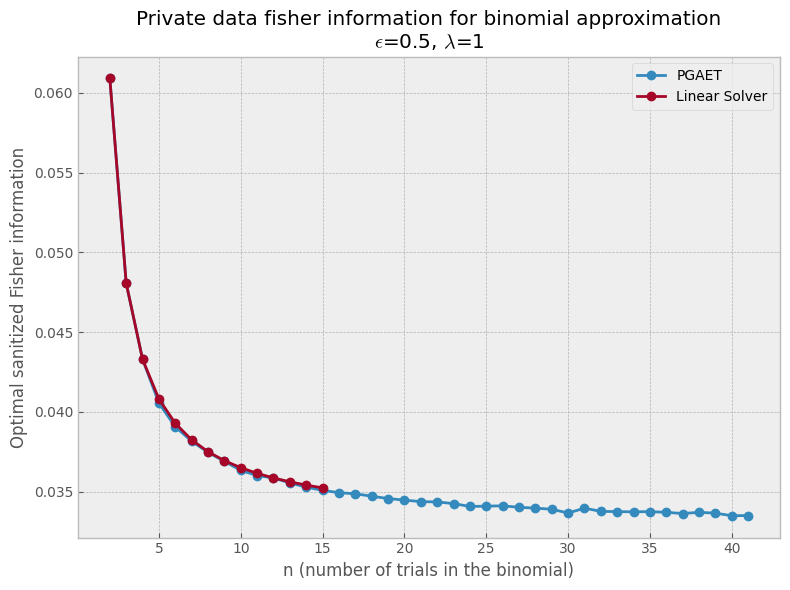

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(ns, pga_best_fishes, 'o-', label="PGAET")
ax.plot(ns[:14], linear_fisher, 'o-', label="Linear Solver")
ax.legend()
ax.set_xlabel("n (number of trials in the binomial)")
ax.set_ylabel("Optimal sanitized Fisher information")
ax.set_title("Private data fisher information for binomial approximation\n" + rf"$\epsilon$={EPSILON}, $\lambda$={LAMBDA}")

plt.tight_layout()
plt.show()

Calculating for n = 2.
Epsilon privacy violation: 0.6698347009682878
Calculating for n = 3.
Epsilon privacy violation: 0.4985256025810906
Calculating for n = 4.
Epsilon privacy violation: 0.14806743445635606
Calculating for n = 5.
Epsilon privacy violation: 0.1833502072598897
Calculating for n = 6.
Epsilon privacy violation: 0.22407292526362854
Calculating for n = 7.
Epsilon privacy violation: 0.20566750751225535
Calculating for n = 8.
Epsilon privacy violation: 0.26523079117340065
Calculating for n = 9.
Epsilon privacy violation: 0.18533176121048334
Calculating for n = 10.
Epsilon privacy violation: 0.07737295852509612
Calculating for n = 11.
Epsilon privacy violation: 0.3017572118259555
Calculating for n = 12.
Epsilon privacy violation: 0.15046669121653067
Calculating for n = 13.
Epsilon privacy violation: 0.12509367128370544
Calculating for n = 14.
Epsilon privacy violation: 0.25751557551098536
Calculating for n = 15.
Epsilon privacy violation: 0.2333160732774919
Calculating for n =

/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Epsilon privacy violation: 0.34339195200129935
Calculating for n = 26.
Epsilon privacy violation: 0.1871574584619849
Calculating for n = 27.
Epsilon privacy violation: 0.9301000794948875
Calculating for n = 28.
Epsilon privacy violation: 0.4911602804661546
Calculating for n = 29.
Epsilon privacy violation: 0.446711770644178
Calculating for n = 30.
Epsilon privacy violation: 0.3388008068890854
Calculating for n = 31.
Epsilon privacy violation: 0.5177889969441652


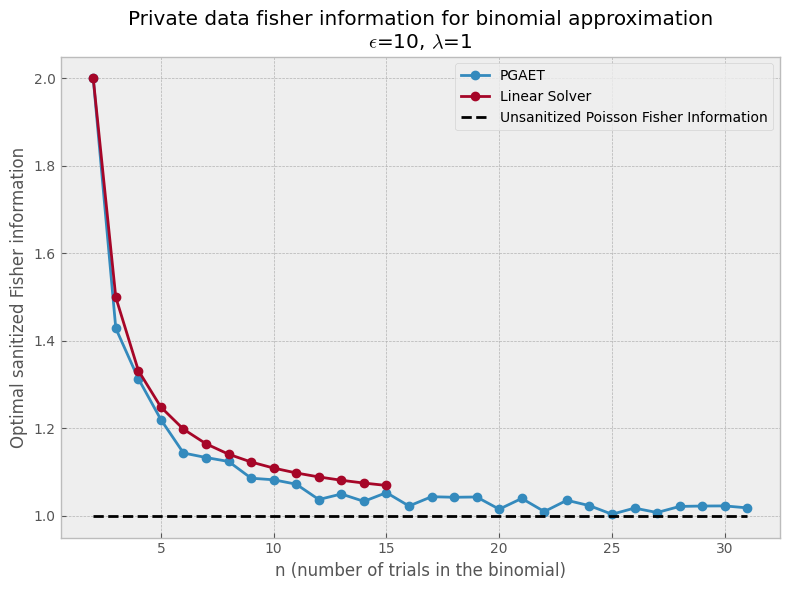

In [7]:
ns = [i + 2 for i in range(30)]
pga_best_fishes = list()
linear_fisher = list()
EPSILON = 10
LAMBDA = 1

pgaet = PGAETMultipleRestarts()
lp = LinearSolver()
for n in ns:
    print(f"Calculating for n = {n}.")
    k = n + 1
    p_theta = binom.pmf(np.arange(k), n, LAMBDA / n)
    p_theta_dot = [(i/LAMBDA - (n-i)/(n-LAMBDA))*binom.pmf(i, n, LAMBDA / n) for i in range(k)]
    
    result = pgaet(p_theta, p_theta_dot, EPSILON, k)
    opt_q = result["Q_matrix"]
    best_fish = fisher_information_privatized(opt_q, p_theta, p_theta_dot)
    pga_best_fishes.append(best_fish)
    if n <= 15:
        result = lp(p_theta, p_theta_dot, EPSILON, k)
        opt_q = result["Q_matrix"]
        best_fish = fisher_information_privatized(opt_q, p_theta, p_theta_dot)
        linear_fisher.append(best_fish)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(ns, pga_best_fishes, 'o-', label="PGAET")
ax.plot(ns[:14], linear_fisher, 'o-', label="Linear Solver")
ax.hlines(1/LAMBDA, ns[0], ns[-1], label="Unsanitized Poisson Fisher Information", linestyles="--", colors=["black"])
ax.legend()
ax.set_xlabel("n (number of trials in the binomial)")
ax.set_ylabel("Optimal sanitized Fisher information")
ax.set_title("Private data fisher information for binomial approximation\n" + rf"$\epsilon$={EPSILON}, $\lambda$={LAMBDA}")

plt.tight_layout()
plt.show()

Calculating for n = 2, epsilon = 0.5.


<>:44: SyntaxWarning: invalid escape sequence '\l'
<>:51: SyntaxWarning: invalid escape sequence '\l'
<>:44: SyntaxWarning: invalid escape sequence '\l'
<>:51: SyntaxWarning: invalid escape sequence '\l'
/var/folders/lv/9hw1_pzj1hs5c2glqrzn04m80000gq/T/ipykernel_61441/2846804410.py:44: SyntaxWarning: invalid escape sequence '\l'
  axes[0].set_ylabel("$I_\lambda(Q)$ (ε = 0.5)")
/var/folders/lv/9hw1_pzj1hs5c2glqrzn04m80000gq/T/ipykernel_61441/2846804410.py:51: SyntaxWarning: invalid escape sequence '\l'
  axes[1].set_ylabel("$I_\lambda(Q)$ (ε = 10)")


Epsilon privacy violation: 3.043931473545314e-07
Calculating for n = 3, epsilon = 0.5.
Epsilon privacy violation: 1.1763225862160276e-05
Calculating for n = 4, epsilon = 0.5.
Epsilon privacy violation: 8.297802567280854e-08
Calculating for n = 5, epsilon = 0.5.
Epsilon privacy violation: 1.6426658020096685e-05
Calculating for n = 6, epsilon = 0.5.
Epsilon privacy violation: 5.219007562728972e-06
Calculating for n = 7, epsilon = 0.5.
Epsilon privacy violation: 2.5067441465576046e-05
Calculating for n = 8, epsilon = 0.5.
Epsilon privacy violation: 3.144762509342883e-05
Calculating for n = 9, epsilon = 0.5.
Epsilon privacy violation: 3.2156023517720955e-05
Calculating for n = 10, epsilon = 0.5.
Epsilon privacy violation: 3.1840774208660716e-05
Calculating for n = 11, epsilon = 0.5.
Epsilon privacy violation: 1.3317881685931399e-05
Calculating for n = 12, epsilon = 0.5.
Epsilon privacy violation: 3.3602502373525356e-06
Calculating for n = 13, epsilon = 0.5.
Epsilon privacy violation: 1.954

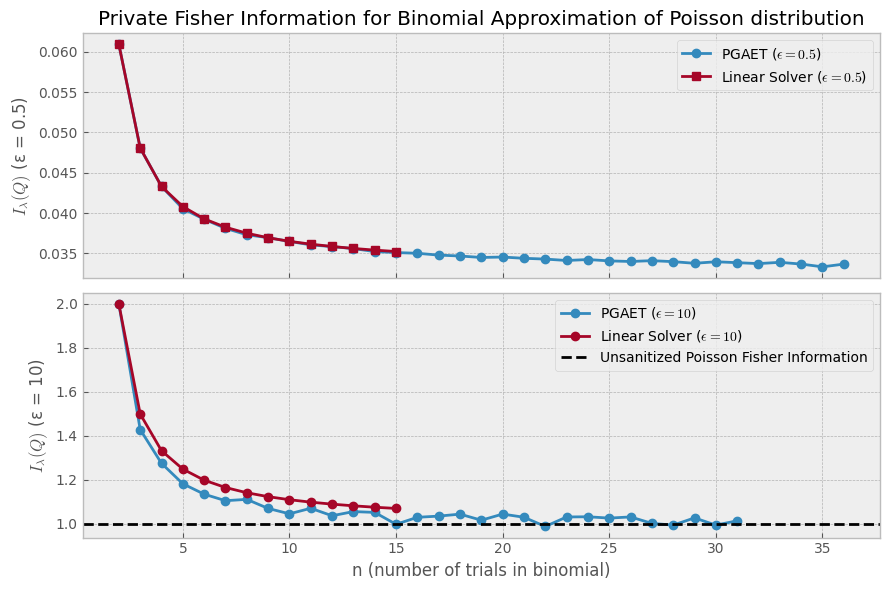

In [8]:
# Constants
EPSILONS = [0.5, 10]
LAMBDA = 1

# Ranges for n
ns_1 = [i + 2 for i in range(35)]  # for epsilon = 0.5
ns_2 = [i + 2 for i in range(30)]  # for epsilon = 10

# Storage for results
results = {0.5: {"ns": ns_1, "pga_best_fishes": [], "linear_fisher": []},
           10: {"ns": ns_2, "pga_best_fishes": [], "linear_fisher": []}}

# Run computations for both epsilon values
for epsilon in EPSILONS:
    ns = results[epsilon]["ns"]
    pgaet = PGAETMultipleRestarts(n_restarts=5)
    lp = LinearSolver()

    for n in ns:
        print(f"Calculating for n = {n}, epsilon = {epsilon}.")
        k = n + 1
        p_theta = binom.pmf(np.arange(k), n, LAMBDA / n)
        p_theta_dot = [(i/LAMBDA - (n-i)/(n-LAMBDA))*binom.pmf(i, n, LAMBDA / n) for i in range(k)]
        
        # Run PGAET
        result = pgaet(p_theta, p_theta_dot, epsilon, k)
        opt_q = result["Q_matrix"]
        best_fish = fisher_information_privatized(opt_q, p_theta, p_theta_dot)
        results[epsilon]["pga_best_fishes"].append(best_fish)

        # Run Linear Solver (only for small n)
        if n <= 15:
            result = lp(p_theta, p_theta_dot, epsilon, k)
            opt_q = result["Q_matrix"]
            best_fish = fisher_information_privatized(opt_q, p_theta, p_theta_dot)
            results[epsilon]["linear_fisher"].append(best_fish)

# Create a single figure with two subplots
fig, axes = plt.subplots(figsize=(9, 6), nrows=2, sharex=True)

# First axis (epsilon = 0.5)
axes[0].plot(results[0.5]["ns"], results[0.5]["pga_best_fishes"], 'o-', label=r"PGAET ($\epsilon = 0.5$)")
axes[0].plot(results[0.5]["ns"][:14], results[0.5]["linear_fisher"], 's-', label=r"Linear Solver ($\epsilon = 0.5$)")
axes[0].set_ylabel("$I_\lambda(Q)$ (ε = 0.5)")
axes[0].set_title("Private Fisher Information for Binomial Approximation of Poisson distribution")
axes[0].legend(loc="upper right")

# Second axis (epsilon = 10)
axes[1].plot(results[10]["ns"], results[10]["pga_best_fishes"],'o-', label=r"PGAET ($\epsilon = 10$)")
axes[1].plot(results[10]["ns"][:14], results[10]["linear_fisher"], 'o-', label=r"Linear Solver ($\epsilon = 10$)")
axes[1].set_ylabel("$I_\lambda(Q)$ (ε = 10)")
axes[1].axhline(1/LAMBDA, color="black", linestyle="--", label="Unsanitized Poisson Fisher Information")
axes[1].legend(loc="upper right")
axes[1].set_xlabel("n (number of trials in binomial)")

plt.tight_layout()
plt.show()


## PGAET fisher inf first 4ns

4it [01:26, 21.68s/it]


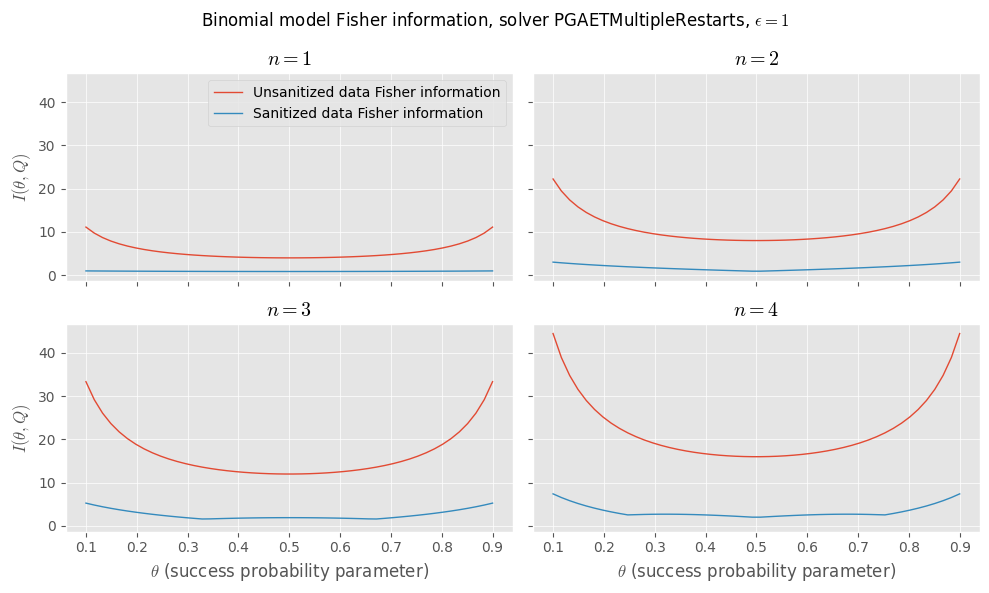

In [2]:
DP_tester.plot_fisher_infos(PGAETMultipleRestarts(), ns=[1, 2, 3, 4], epsilon=1)

## PGAET high vs low privacy

  0%|          | 0/51 [00:00<?, ?it/s]

Epsilon privacy violation: 2.0106022069477092e-08


  2%|▏         | 1/51 [00:10<08:50, 10.61s/it]

Epsilon privacy violation: 0.0004752700143700883
Epsilon privacy violation: 3.317119283141601e-07


  4%|▍         | 2/51 [00:19<07:52,  9.65s/it]

Epsilon privacy violation: 0.00011754195492852393
Epsilon privacy violation: 1.4286310583311312e-05


  6%|▌         | 3/51 [00:26<06:34,  8.23s/it]

Epsilon privacy violation: 6.588445622690564e-05
Epsilon privacy violation: 1.2172421531619904e-05


  8%|▊         | 4/51 [00:34<06:33,  8.37s/it]

Epsilon privacy violation: 0.001527772489694379
Epsilon privacy violation: 1.3642669546065633e-05


 10%|▉         | 5/51 [00:40<05:49,  7.60s/it]

Epsilon privacy violation: 6.294384741212244e-05
Epsilon privacy violation: 5.601505095376158e-06


 12%|█▏        | 6/51 [00:45<04:59,  6.65s/it]

Epsilon privacy violation: 0.0004256448179524863
Epsilon privacy violation: 1.5460013858881183e-05


 14%|█▎        | 7/51 [00:51<04:33,  6.21s/it]

Epsilon privacy violation: 0.0005091821869849245
Epsilon privacy violation: 3.5686794776501607e-06


 16%|█▌        | 8/51 [00:55<04:02,  5.65s/it]

Epsilon privacy violation: 0.0012224646369348724
Epsilon privacy violation: 3.412800246682668e-06


 18%|█▊        | 9/51 [00:59<03:31,  5.03s/it]

Epsilon privacy violation: 0.0004673690092752425
Epsilon privacy violation: 9.89786003158244e-09


 20%|█▉        | 10/51 [01:03<03:20,  4.89s/it]

Epsilon privacy violation: 0.0014613137666229514
Epsilon privacy violation: 2.51292646207546e-05


 22%|██▏       | 11/51 [01:08<03:08,  4.70s/it]

Epsilon privacy violation: 0.0013236431330236886
Epsilon privacy violation: 1.2908353691665209e-05


 24%|██▎       | 12/51 [01:13<03:09,  4.87s/it]

Epsilon privacy violation: 0.0014909740075368383
Epsilon privacy violation: 7.660628193462138e-07


 25%|██▌       | 13/51 [01:26<04:45,  7.52s/it]

Epsilon privacy violation: 0.0025683314748153885
Epsilon privacy violation: 2.1733607376617226e-05


 27%|██▋       | 14/51 [01:38<05:20,  8.67s/it]

Epsilon privacy violation: 0.0007572948984349015
Epsilon privacy violation: 6.594246128310832e-09


 29%|██▉       | 15/51 [01:48<05:26,  9.07s/it]

Epsilon privacy violation: 0.0014698025259708425
Epsilon privacy violation: 2.611507573080374e-06


 31%|███▏      | 16/51 [01:52<04:26,  7.61s/it]

Epsilon privacy violation: 0.001086557546351341
Epsilon privacy violation: 4.481107577447574e-05


 33%|███▎      | 17/51 [02:03<04:56,  8.71s/it]

Epsilon privacy violation: 0.0001886658055223693
Epsilon privacy violation: 4.94733849665252e-07


 35%|███▌      | 18/51 [02:15<05:17,  9.63s/it]

Epsilon privacy violation: 0.002417575709895075
Epsilon privacy violation: 1.3192122761296332e-05


 37%|███▋      | 19/51 [02:24<04:57,  9.31s/it]

Epsilon privacy violation: 0.0017754727155211425
Epsilon privacy violation: 6.044464906040936e-05


 39%|███▉      | 20/51 [02:36<05:14, 10.15s/it]

Epsilon privacy violation: 0.000873570417008751
Epsilon privacy violation: 4.0093942284126544e-09


 41%|████      | 21/51 [02:46<05:01, 10.06s/it]

Epsilon privacy violation: 0.0009752368906460473
Epsilon privacy violation: 5.660411383477064e-09


 43%|████▎     | 22/51 [02:56<04:56, 10.23s/it]

Epsilon privacy violation: 0.0006821417151102738
Epsilon privacy violation: 1.2589679493357764e-08


 45%|████▌     | 23/51 [03:09<05:10, 11.08s/it]

Epsilon privacy violation: 0.0011425397741127163
Epsilon privacy violation: 1.155135874286728e-06


 47%|████▋     | 24/51 [03:17<04:31, 10.07s/it]

Epsilon privacy violation: 0.0008566801687244219
Epsilon privacy violation: 4.8130260420629264e-09


 49%|████▉     | 25/51 [03:27<04:25, 10.20s/it]

Epsilon privacy violation: 4.674472144627906e-05
Epsilon privacy violation: 4.062408271666832e-09


 51%|█████     | 26/51 [03:39<04:24, 10.59s/it]

Epsilon privacy violation: 0.00048788938490584854
Epsilon privacy violation: 5.339223061972283e-06


 53%|█████▎    | 27/51 [03:47<03:57,  9.89s/it]

Epsilon privacy violation: 0.0012618663144119413
Epsilon privacy violation: 1.9017538250162835e-05


 55%|█████▍    | 28/51 [04:02<04:21, 11.36s/it]

Epsilon privacy violation: 0.00045325621652325676
Epsilon privacy violation: 4.918007046117445e-05


 57%|█████▋    | 29/51 [04:08<03:34,  9.77s/it]

Epsilon privacy violation: 1.270725347446433e-05
Epsilon privacy violation: 3.6092908642426647e-05


 59%|█████▉    | 30/51 [04:15<03:10,  9.05s/it]

Epsilon privacy violation: 0.0008681639854536405
Epsilon privacy violation: 4.015494488074367e-05


 61%|██████    | 31/51 [04:22<02:46,  8.33s/it]

Epsilon privacy violation: 0.00015704184639520058
Epsilon privacy violation: 4.4329406242438196e-05


 63%|██████▎   | 32/51 [04:29<02:30,  7.93s/it]

Epsilon privacy violation: 0.002198718606100658
Epsilon privacy violation: 4.916016735778683e-05


 65%|██████▍   | 33/51 [04:36<02:15,  7.53s/it]

Epsilon privacy violation: 3.478994632442417e-08
Epsilon privacy violation: 2.948246341499816e-05


 67%|██████▋   | 34/51 [04:42<02:01,  7.17s/it]

Epsilon privacy violation: 1.4674182372553801e-06
Epsilon privacy violation: 2.201328830997328e-05


 69%|██████▊   | 35/51 [04:54<02:16,  8.51s/it]

Epsilon privacy violation: 2.2504766359010553e-05
Epsilon privacy violation: 2.917755499809438e-05


 71%|███████   | 36/51 [04:56<01:42,  6.81s/it]

Epsilon privacy violation: 0.0019475216069121393
Epsilon privacy violation: 1.920666845975066e-05


 73%|███████▎  | 37/51 [05:01<01:25,  6.13s/it]

Epsilon privacy violation: 6.308000011223669e-09
Epsilon privacy violation: 7.249441633105924e-06


 75%|███████▍  | 38/51 [05:16<01:52,  8.65s/it]

Epsilon privacy violation: 1.8421304106841507e-05
Epsilon privacy violation: 4.6626345973077576e-07


 76%|███████▋  | 39/51 [05:23<01:40,  8.33s/it]

Epsilon privacy violation: 0.0001873930691500717
Epsilon privacy violation: 4.355979976333746e-06


 78%|███████▊  | 40/51 [05:32<01:33,  8.49s/it]

Epsilon privacy violation: 0.0014025449590098216
Epsilon privacy violation: 3.355057591802879e-05


 80%|████████  | 41/51 [05:40<01:24,  8.42s/it]

Epsilon privacy violation: 0.002423393519624173
Epsilon privacy violation: 5.3606365261194e-05


 82%|████████▏ | 42/51 [05:44<01:03,  7.08s/it]

Epsilon privacy violation: 0.0017074892268867936
Epsilon privacy violation: 6.562062866255491e-06


 84%|████████▍ | 43/51 [05:49<00:50,  6.33s/it]

Epsilon privacy violation: 0.0021173943068748535
Epsilon privacy violation: 6.330673558441191e-05


 86%|████████▋ | 44/51 [05:53<00:39,  5.60s/it]

Epsilon privacy violation: 2.0834174339845468e-05
Epsilon privacy violation: 4.372749025105538e-05


 88%|████████▊ | 45/51 [05:56<00:29,  4.94s/it]

Epsilon privacy violation: 0.00014936706359991447
Epsilon privacy violation: 1.2280473926651325e-07


 90%|█████████ | 46/51 [06:00<00:23,  4.60s/it]

Epsilon privacy violation: 1.7973800148785024e-06
Epsilon privacy violation: 4.1516117989859325e-05


 92%|█████████▏| 47/51 [06:03<00:16,  4.20s/it]

Epsilon privacy violation: 0.00030047222757645375
Epsilon privacy violation: 1.76950357190786e-05


 94%|█████████▍| 48/51 [06:08<00:13,  4.35s/it]

Epsilon privacy violation: 0.00013333939393100902
Epsilon privacy violation: 9.12122864180076e-06


 96%|█████████▌| 49/51 [06:13<00:09,  4.64s/it]

Epsilon privacy violation: 7.96971157193127e-05
Epsilon privacy violation: 1.28111356813565e-05


 98%|█████████▊| 50/51 [06:20<00:05,  5.20s/it]

Epsilon privacy violation: 9.367649784985943e-05
Epsilon privacy violation: 7.556405370201524e-06


100%|██████████| 51/51 [06:26<00:00,  7.58s/it]

Epsilon privacy violation: 2.339189064670677e-08


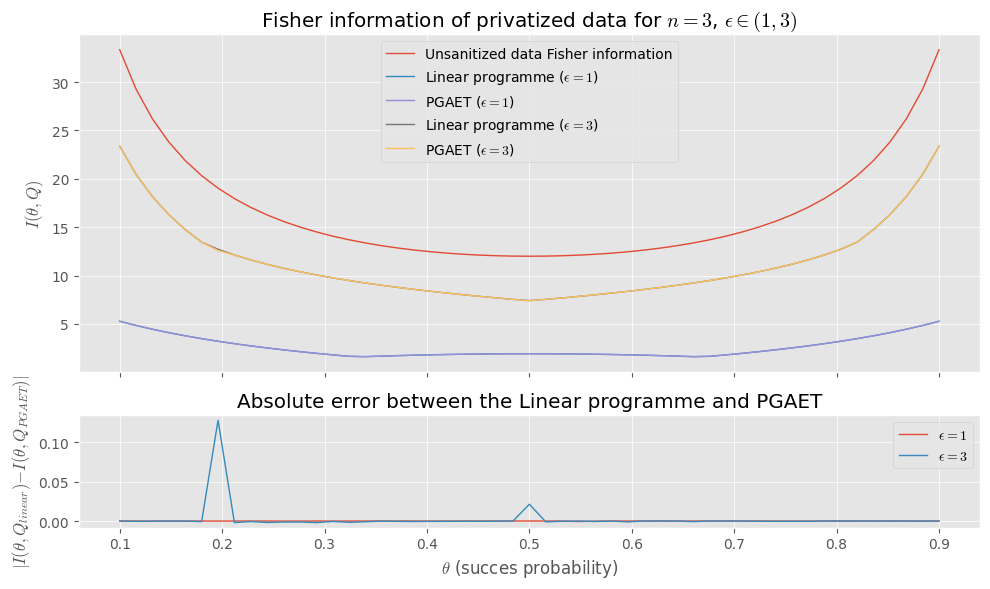

In [2]:
N = 3
EPSILON1 = 1
EPSILON2 = 3
LINEWIDTH = 1
lr = LinearSolver()
pg = PGAETMultipleRestarts(n_restarts=10)

thetas = np.linspace(1e-1, 1 - 1e-1, 51)

orig_fisher_infs = fisher_information_binom(N, thetas)

lr_fishers_high_priv = list()
lr_fisher_low_priv = list()
pg_fishers_high_priv = list()
pg_fishers_low_priv = list()
opt_qs_high_priv = list()
for theta in tqdm(thetas):
    _, _, _, fish = binom_optimal_privacy(
        lr, N, EPSILON1, theta
    )
    lr_fishers_high_priv.append(fish)
    _, _, _, fish = binom_optimal_privacy(
        lr, N, EPSILON2, theta
    )
    lr_fisher_low_priv.append(fish)

    _, _, _, fish = binom_optimal_privacy(
        pg, N, EPSILON1, theta
    )
    pg_fishers_high_priv.append(fish)
    q, _, _, fish = binom_optimal_privacy(
        pg, N, EPSILON2, theta
    )
    opt_qs_high_priv.append(q)
    pg_fishers_low_priv.append(fish)

fig, ax = plt.subplots(figsize=(10, 6), nrows=2, sharex=True, height_ratios=(3, 1))

ax[0].plot(thetas, orig_fisher_infs, label="Unsanitized data Fisher information", linewidth=LINEWIDTH)

ax[0].plot(thetas, lr_fishers_high_priv, label=rf"Linear programme ($\epsilon={EPSILON1}$)", linewidth=LINEWIDTH)
ax[0].plot(thetas, pg_fishers_high_priv, label=rf"PGAET ($\epsilon={EPSILON1}$)", linewidth=LINEWIDTH)

ax[0].plot(thetas, lr_fisher_low_priv, label=rf"Linear programme ($\epsilon={EPSILON2}$)", linewidth=LINEWIDTH)
ax[0].plot(thetas, pg_fishers_low_priv, label=rf"PGAET ($\epsilon={EPSILON2}$)", linewidth=LINEWIDTH)

ax[0].set_ylabel(r"$I(\theta, Q)$")
ax[0].set_title(
    rf"Fisher information of privatized data for $n={N}$, $\epsilon \in ({EPSILON1}, {EPSILON2})$"
)
ax[0].legend(fontsize="medium")

# error plot
ax[1].plot(thetas, np.array(lr_fishers_high_priv) - np.array(pg_fishers_high_priv), label=rf"$\epsilon={EPSILON1}$", linewidth=LINEWIDTH)
ax[1].plot(thetas, np.array(lr_fisher_low_priv) - np.array(pg_fishers_low_priv), label=rf"$\epsilon={EPSILON2}$", linewidth=LINEWIDTH)
ax[1].set_title("Absolute error between the Linear programme and PGAET")
ax[1].set_ylabel(r"$|I(\theta, Q_{linear})$" + r"$- I(\theta, Q_{PGAET})|$")
ax[1].set_xlabel(r"$\theta$ (succes probability)")
ax[1].legend(fontsize="medium")

plt.tight_layout()
plt.savefig("figures/n_3_low_and_high_eps")
plt.show()

  0%|          | 0/51 [00:00<?, ?it/s]

Epsilon privacy violation: 2.7814388071284446e-05


  2%|▏         | 1/51 [00:36<30:05, 36.12s/it]

Epsilon privacy violation: 3.1426458690919645e-07
Epsilon privacy violation: 1.0629495599684402e-07


  4%|▍         | 2/51 [01:11<29:16, 35.84s/it]

Epsilon privacy violation: 0.00024097744252360442
Epsilon privacy violation: 4.904143352524315e-08


  6%|▌         | 3/51 [01:51<30:11, 37.74s/it]

Epsilon privacy violation: 0.0013591165793316318
Epsilon privacy violation: 2.5537121095542403e-07


  8%|▊         | 4/51 [02:25<28:16, 36.09s/it]

Epsilon privacy violation: 0.0056681954057269945
Epsilon privacy violation: 2.115422263415656e-06


 10%|▉         | 5/51 [03:05<28:45, 37.50s/it]

Epsilon privacy violation: 0.001962854131373204
Epsilon privacy violation: 1.7870030787484248e-07


 12%|█▏        | 6/51 [03:41<27:52, 37.17s/it]

Epsilon privacy violation: 6.966779649497656e-05
Epsilon privacy violation: 1.3638036099328232e-06


 14%|█▎        | 7/51 [04:31<30:22, 41.41s/it]

Epsilon privacy violation: 8.602945012026186e-05
Epsilon privacy violation: 8.587887101674241e-06


 16%|█▌        | 8/51 [05:23<32:03, 44.74s/it]

Epsilon privacy violation: 8.387051686487013e-07
Epsilon privacy violation: 5.687007893079299e-08


 18%|█▊        | 9/51 [06:17<33:18, 47.58s/it]

Epsilon privacy violation: 1.4396728876819864e-06
Epsilon privacy violation: 1.224724351897577e-05


 20%|█▉        | 10/51 [06:52<29:43, 43.51s/it]

Epsilon privacy violation: 7.481683524823701e-06
Epsilon privacy violation: 1.724877086276e-05


 22%|██▏       | 11/51 [07:22<26:15, 39.39s/it]

Epsilon privacy violation: 1.1791776468594861e-06
Epsilon privacy violation: 2.0947086969563822e-05


 24%|██▎       | 12/51 [07:48<23:07, 35.57s/it]

Epsilon privacy violation: 0.0003697373698740569
Epsilon privacy violation: 1.9184091981649942e-06


 25%|██▌       | 13/51 [08:18<21:26, 33.86s/it]

Epsilon privacy violation: 0.00022146298802216968
Epsilon privacy violation: 2.1785864074086447e-05


 27%|██▋       | 14/51 [08:48<20:10, 32.71s/it]

Epsilon privacy violation: 0.00021651613248319102
Epsilon privacy violation: 2.165968171063959e-05


 29%|██▉       | 15/51 [09:23<19:52, 33.12s/it]

Epsilon privacy violation: 3.163193918687135e-06
Epsilon privacy violation: 1.4158559040189367e-05


 31%|███▏      | 16/51 [09:51<18:28, 31.67s/it]

Epsilon privacy violation: 5.837817703890913e-05
Epsilon privacy violation: 4.086094023525444e-06


 33%|███▎      | 17/51 [10:22<17:51, 31.50s/it]

Epsilon privacy violation: 0.00019146469120645548
Epsilon privacy violation: 3.504166833601108e-05


 35%|███▌      | 18/51 [10:49<16:37, 30.21s/it]

Epsilon privacy violation: 0.0001936947730908356
Epsilon privacy violation: 1.3417862256715554e-05


 37%|███▋      | 19/51 [11:20<16:16, 30.51s/it]

Epsilon privacy violation: 0.0005003203250065758
Epsilon privacy violation: 1.5894118611914365e-05


 39%|███▉      | 20/51 [11:47<15:05, 29.22s/it]

Epsilon privacy violation: 0.008329387282226541
Epsilon privacy violation: 1.066613906852698e-05


 41%|████      | 21/51 [12:17<14:43, 29.45s/it]

Epsilon privacy violation: 2.4849611231392288e-05
Epsilon privacy violation: 1.582489490811745e-05


 43%|████▎     | 22/51 [12:44<13:55, 28.81s/it]

Epsilon privacy violation: 1.9804430340109036e-07
Epsilon privacy violation: 3.679520866428643e-05


 45%|████▌     | 23/51 [13:07<12:41, 27.19s/it]

Epsilon privacy violation: 0.0019351922295096635
Epsilon privacy violation: 3.546637072538231e-05


 47%|████▋     | 24/51 [13:29<11:27, 25.46s/it]

Epsilon privacy violation: 0.0011870917303508088
Epsilon privacy violation: 2.8781200928085227e-06


 49%|████▉     | 25/51 [13:56<11:15, 25.98s/it]

Epsilon privacy violation: 0.0276398779470155
Epsilon privacy violation: 5.012862851205835e-06


 51%|█████     | 26/51 [14:25<11:13, 26.93s/it]

Epsilon privacy violation: 0.00541305435169126
Epsilon privacy violation: 2.4687893074689467e-05


 53%|█████▎    | 27/51 [14:57<11:24, 28.52s/it]

Epsilon privacy violation: 0.0004734612861313492
Epsilon privacy violation: 2.654147751973701e-05


 55%|█████▍    | 28/51 [15:12<09:21, 24.40s/it]

Epsilon privacy violation: 0.0006008811180390206
Epsilon privacy violation: 1.7114405779145025e-05


 57%|█████▋    | 29/51 [15:27<07:55, 21.61s/it]

Epsilon privacy violation: 0.0014583687064845252
Epsilon privacy violation: 2.7067419701043427e-05


 59%|█████▉    | 30/51 [15:49<07:38, 21.83s/it]

Epsilon privacy violation: 1.404105802493838e-05
Epsilon privacy violation: 2.7546313910256577e-05


 61%|██████    | 31/51 [16:18<07:55, 23.80s/it]

Epsilon privacy violation: 2.130896743057775e-06
Epsilon privacy violation: 2.071359411610907e-05


 63%|██████▎   | 32/51 [16:37<07:05, 22.39s/it]

Epsilon privacy violation: 4.1692297193529626e-05
Epsilon privacy violation: 1.800332280183022e-05


 65%|██████▍   | 33/51 [17:02<06:58, 23.25s/it]

Epsilon privacy violation: 0.011042262648897405
Epsilon privacy violation: 1.2544232638132178e-05


 67%|██████▋   | 34/51 [17:28<06:48, 24.04s/it]

Epsilon privacy violation: 9.454250317231239e-06
Epsilon privacy violation: 2.2192265221654406e-05


 69%|██████▊   | 35/51 [17:55<06:39, 25.00s/it]

Epsilon privacy violation: 0.002226001824590651
Epsilon privacy violation: 2.6578014535733052e-05


 71%|███████   | 36/51 [18:12<05:35, 22.34s/it]

Epsilon privacy violation: 0.0009812326579941022
Epsilon privacy violation: 1.79317648997257e-05


 73%|███████▎  | 37/51 [18:25<04:36, 19.73s/it]

Epsilon privacy violation: 0.00027231715143249957
Epsilon privacy violation: 8.563780199977167e-06


 75%|███████▍  | 38/51 [18:46<04:21, 20.10s/it]

Epsilon privacy violation: 0.0001637760192268467
Epsilon privacy violation: 7.062108685340629e-06


 76%|███████▋  | 39/51 [19:00<03:39, 18.31s/it]

Epsilon privacy violation: 0.0005961488513195334
Epsilon privacy violation: 5.76189441159336e-08


 78%|███████▊  | 40/51 [19:19<03:23, 18.50s/it]

Epsilon privacy violation: 0.0005410635044975076
Epsilon privacy violation: 8.760713897659755e-06


 80%|████████  | 41/51 [19:38<03:06, 18.62s/it]

Epsilon privacy violation: 0.00030574658794702003
Epsilon privacy violation: 5.560430902773472e-06


 82%|████████▏ | 42/51 [20:10<03:23, 22.64s/it]

Epsilon privacy violation: 3.437687786900234e-05
Epsilon privacy violation: 4.426211348329545e-06


 84%|████████▍ | 43/51 [20:43<03:25, 25.74s/it]

Epsilon privacy violation: 0.00031464326476260407
Epsilon privacy violation: 1.1918694359236426e-07


 86%|████████▋ | 44/51 [21:24<03:32, 30.34s/it]

Epsilon privacy violation: 4.850363088948484e-07
Epsilon privacy violation: 7.44410811292541e-06


 88%|████████▊ | 45/51 [22:13<03:35, 35.87s/it]

Epsilon privacy violation: 0.00023337774663068078
Epsilon privacy violation: 1.0577453932736347e-06


 90%|█████████ | 46/51 [22:56<03:10, 38.14s/it]

Epsilon privacy violation: 4.982812816523019e-06
Epsilon privacy violation: 1.9891194655285993e-07


 92%|█████████▏| 47/51 [23:31<02:28, 37.23s/it]

Epsilon privacy violation: 0.0005759377074102678
Epsilon privacy violation: 2.5830531766857234e-06


 94%|█████████▍| 48/51 [24:03<01:46, 35.66s/it]

Epsilon privacy violation: 1.2684456902778418e-05
Epsilon privacy violation: 1.581178834563629e-05


 96%|█████████▌| 49/51 [24:38<01:10, 35.41s/it]

Epsilon privacy violation: 0.0007125088807415358
Epsilon privacy violation: 1.059348966364615e-05


 98%|█████████▊| 50/51 [25:12<00:34, 34.78s/it]

Epsilon privacy violation: 3.171447210070788e-06
Epsilon privacy violation: 2.306261254192421e-08


100%|██████████| 51/51 [25:50<00:00, 30.39s/it]

Epsilon privacy violation: 0.000521188546832585


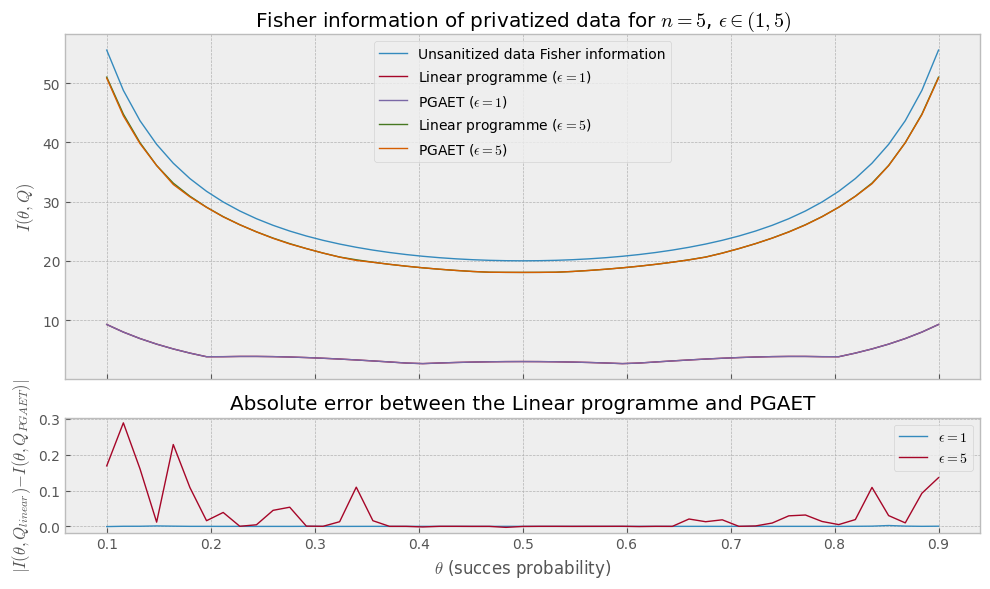

In [9]:
N = 5
EPSILON1 = 1
EPSILON2 = 5
LINEWIDTH = 1
lr = LinearSolver()
pg = PGAETMultipleRestarts(n_restarts=10)

thetas = np.linspace(1e-1, 1 - 1e-1, 51)

orig_fisher_infs = fisher_information_binom(N, thetas)

lr_fishers_high_priv = list()
lr_fisher_low_priv = list()
pg_fishers_high_priv = list()
pg_fishers_low_priv = list()
opt_qs_high_priv = list()
for theta in tqdm(thetas):
    _, _, _, fish = binom_optimal_privacy(
        lr, N, EPSILON1, theta
    )
    lr_fishers_high_priv.append(fish)
    _, _, _, fish = binom_optimal_privacy(
        lr, N, EPSILON2, theta
    )
    lr_fisher_low_priv.append(fish)

    _, _, _, fish = binom_optimal_privacy(
        pg, N, EPSILON1, theta
    )
    pg_fishers_high_priv.append(fish)
    q, _, _, fish = binom_optimal_privacy(
        pg, N, EPSILON2, theta
    )
    opt_qs_high_priv.append(q)
    pg_fishers_low_priv.append(fish)

fig, ax = plt.subplots(figsize=(10, 6), nrows=2, sharex=True, height_ratios=(3, 1))

ax[0].plot(thetas, orig_fisher_infs, label="Unsanitized data Fisher information", linewidth=LINEWIDTH)

ax[0].plot(thetas, lr_fishers_high_priv, label=rf"Linear programme ($\epsilon={EPSILON1}$)", linewidth=LINEWIDTH)
ax[0].plot(thetas, pg_fishers_high_priv, label=rf"PGAET ($\epsilon={EPSILON1}$)", linewidth=LINEWIDTH)

ax[0].plot(thetas, lr_fisher_low_priv, label=rf"Linear programme ($\epsilon={EPSILON2}$)", linewidth=LINEWIDTH)
ax[0].plot(thetas, pg_fishers_low_priv, label=rf"PGAET ($\epsilon={EPSILON2}$)", linewidth=LINEWIDTH)

ax[0].set_ylabel(r"$I(\theta, Q)$")
ax[0].set_title(
    rf"Fisher information of privatized data for $n={N}$, $\epsilon \in ({EPSILON1}, {EPSILON2})$"
)
ax[0].legend(fontsize="medium")

# error plot
ax[1].plot(thetas, np.array(lr_fishers_high_priv) - np.array(pg_fishers_high_priv), label=rf"$\epsilon={EPSILON1}$", linewidth=LINEWIDTH)
ax[1].plot(thetas, np.array(lr_fisher_low_priv) - np.array(pg_fishers_low_priv), label=rf"$\epsilon={EPSILON2}$", linewidth=LINEWIDTH)
ax[1].set_title("Absolute error between the Linear programme and PGAET")
ax[1].set_ylabel(r"$|I(\theta, Q_{linear})$" + r"$- I(\theta, Q_{PGAET})|$")
ax[1].set_xlabel(r"$\theta$ (succes probability)")
ax[1].legend(fontsize="medium")

plt.tight_layout()
plt.savefig("figures/n_5_low_and_high_eps")
plt.show()

  0%|          | 0/51 [00:00<?, ?it/s]

Epsilon privacy violation: 3.364807386133095e-05


  2%|▏         | 1/51 [04:06<3:25:02, 246.06s/it]

Epsilon privacy violation: 0.00565836015055704
Epsilon privacy violation: 1.9658262974980856e-05


  4%|▍         | 2/51 [07:31<3:01:19, 222.03s/it]

Epsilon privacy violation: 0.01162469774008007
Epsilon privacy violation: 2.0665070763759008e-05


  6%|▌         | 3/51 [10:06<2:33:04, 191.35s/it]

Epsilon privacy violation: 0.0019369451120349046
Epsilon privacy violation: 4.8057540319476665e-05


  8%|▊         | 4/51 [12:14<2:10:32, 166.65s/it]

Epsilon privacy violation: 0.00021656806236719506
Epsilon privacy violation: 1.1230007682756869e-05


 10%|▉         | 5/51 [14:22<1:57:04, 152.72s/it]

Epsilon privacy violation: 0.0006298381783339524
Epsilon privacy violation: 9.497256925339315e-06


 12%|█▏        | 6/51 [16:43<1:51:26, 148.59s/it]

Epsilon privacy violation: 0.0019055565307376787
Epsilon privacy violation: 1.260718980626574e-05


 14%|█▎        | 7/51 [19:05<1:47:16, 146.28s/it]

Epsilon privacy violation: 0.00034771792265320123
Epsilon privacy violation: 4.678858888203872e-06


 16%|█▌        | 8/51 [21:10<1:40:04, 139.64s/it]

Epsilon privacy violation: 0.0005966854652868503
Epsilon privacy violation: 2.6245282564230088e-05


 18%|█▊        | 9/51 [23:03<1:31:59, 131.42s/it]

Epsilon privacy violation: 0.0016280473560638525
Epsilon privacy violation: 1.5648111978794343e-05


 20%|█▉        | 10/51 [25:22<1:31:25, 133.78s/it]

Epsilon privacy violation: 0.00028677702016416395
Epsilon privacy violation: 4.260550142631825e-06


 22%|██▏       | 11/51 [26:43<1:18:16, 117.41s/it]

Epsilon privacy violation: 0.00017796939862996242
Epsilon privacy violation: 8.600845968931292e-06


 24%|██▎       | 12/51 [28:09<1:10:09, 107.93s/it]

Epsilon privacy violation: 9.975185855842783e-05
Epsilon privacy violation: 1.4334611303512546e-08


 25%|██▌       | 13/51 [29:44<1:05:54, 104.06s/it]

Epsilon privacy violation: 0.0011974833925282313
Epsilon privacy violation: 1.1334831463705175e-05


 27%|██▋       | 14/51 [31:28<1:04:04, 103.91s/it]

Epsilon privacy violation: 0.0006899179385101428
Epsilon privacy violation: 2.0856019086094933e-06


 29%|██▉       | 15/51 [33:05<1:01:12, 102.01s/it]

Epsilon privacy violation: 0.0004603035402428457
Epsilon privacy violation: 4.223586627938314e-06


 31%|███▏      | 16/51 [34:31<56:37, 97.07s/it]   

Epsilon privacy violation: 0.0013693081423162279
Epsilon privacy violation: 1.1845355714544537e-05


 33%|███▎      | 17/51 [35:44<50:59, 89.98s/it]

Epsilon privacy violation: 0.001413408000543681
Epsilon privacy violation: 7.858449654951638e-06


 35%|███▌      | 18/51 [37:01<47:18, 86.03s/it]

Epsilon privacy violation: 0.0006359185956768543
Epsilon privacy violation: 9.35750672267921e-06


 37%|███▋      | 19/51 [38:25<45:29, 85.31s/it]

Epsilon privacy violation: 0.0005961493232024551
Epsilon privacy violation: 1.2823603090100777e-05


 39%|███▉      | 20/51 [55:46<3:12:18, 372.22s/it]

Epsilon privacy violation: 0.0003825580226616554
Epsilon privacy violation: 1.773663122354996e-05


 41%|████      | 21/51 [57:17<2:23:55, 287.84s/it]

Epsilon privacy violation: 0.00010296773566897954
Epsilon privacy violation: 2.420680582471829e-06


 43%|████▎     | 22/51 [58:38<1:49:07, 225.76s/it]

Epsilon privacy violation: 0.0029550628886347297
Epsilon privacy violation: 2.5490477666700873e-06


 45%|████▌     | 23/51 [1:00:04<1:25:48, 183.86s/it]

Epsilon privacy violation: 0.0008911156354054484
Epsilon privacy violation: 2.946904008975515e-06


 47%|████▋     | 24/51 [1:01:25<1:08:48, 152.90s/it]

Epsilon privacy violation: 0.0003068887184537461
Epsilon privacy violation: 1.5475557932770334e-06


 49%|████▉     | 25/51 [1:02:50<57:32, 132.77s/it]  

Epsilon privacy violation: 0.00010752640455891083
Epsilon privacy violation: 1.186792781280449e-05


 51%|█████     | 26/51 [1:04:16<49:28, 118.74s/it]

Epsilon privacy violation: 0.0003349025391864435
Epsilon privacy violation: 2.3939159981833935e-06


 53%|█████▎    | 27/51 [1:06:26<48:46, 121.95s/it]

Epsilon privacy violation: 6.043141747008596e-05
Epsilon privacy violation: 2.9555580757928412e-06


 55%|█████▍    | 28/51 [1:24:01<2:34:04, 401.94s/it]

Epsilon privacy violation: 0.0006334465244702825
Epsilon privacy violation: 1.374985455424027e-06


 57%|█████▋    | 29/51 [1:25:18<1:51:37, 304.45s/it]

Epsilon privacy violation: 0.0005189018688221969
Epsilon privacy violation: 8.288249020493854e-06


 59%|█████▉    | 30/51 [1:26:49<1:24:08, 240.42s/it]

Epsilon privacy violation: 9.476282231302147e-05
Epsilon privacy violation: 1.4475433185723308e-06


 61%|██████    | 31/51 [1:28:19<1:05:04, 195.24s/it]

Epsilon privacy violation: 0.00039787928416068485
Epsilon privacy violation: 2.3938450777194475e-08


 63%|██████▎   | 32/51 [1:29:51<52:00, 164.24s/it]  

Epsilon privacy violation: 0.0007885336869105364
Epsilon privacy violation: 1.4172414889192157e-06


 65%|██████▍   | 33/51 [1:31:29<43:19, 144.41s/it]

Epsilon privacy violation: 0.00031050393528081477
Epsilon privacy violation: 4.54665501460616e-06


 67%|██████▋   | 34/51 [1:32:54<35:52, 126.63s/it]

Epsilon privacy violation: 0.00029087932628085733
Epsilon privacy violation: 4.929024910310664e-07


 69%|██████▊   | 35/51 [1:34:10<29:42, 111.39s/it]

Epsilon privacy violation: 0.0011499338356157351
Epsilon privacy violation: 9.788289953210905e-06


 71%|███████   | 36/51 [1:35:26<25:13, 100.92s/it]

Epsilon privacy violation: 0.0002958030937130762
Epsilon privacy violation: 2.988815745404161e-06


 73%|███████▎  | 37/51 [1:37:25<24:47, 106.28s/it]

Epsilon privacy violation: 0.0004804484664224784
Epsilon privacy violation: 4.161794979066066e-06


 75%|███████▍  | 38/51 [1:39:08<22:48, 105.24s/it]

Epsilon privacy violation: 0.0005233732804305058
Epsilon privacy violation: 2.731881151712967e-06


 76%|███████▋  | 39/51 [1:41:04<21:42, 108.50s/it]

Epsilon privacy violation: 0.0003597703412503428
Epsilon privacy violation: 1.7204435746598357e-06


 78%|███████▊  | 40/51 [1:42:23<18:15, 99.60s/it] 

Epsilon privacy violation: 0.0002994798746880356
Epsilon privacy violation: 1.1957337126000667e-07


 80%|████████  | 41/51 [1:43:53<16:08, 96.83s/it]

Epsilon privacy violation: 0.0006386176054193893
Epsilon privacy violation: 4.192311616330047e-06


 82%|████████▏ | 42/51 [1:45:30<14:30, 96.68s/it]

Epsilon privacy violation: 0.00012132540582443507
Epsilon privacy violation: 1.7675133437543542e-06


 84%|████████▍ | 43/51 [1:47:04<12:47, 95.90s/it]

Epsilon privacy violation: 9.841427707424355e-05
Epsilon privacy violation: 1.0964103215604926e-06


 86%|████████▋ | 44/51 [1:48:42<11:15, 96.53s/it]

Epsilon privacy violation: 0.000714314114954484
Epsilon privacy violation: 9.647594091949329e-07


 88%|████████▊ | 45/51 [1:50:26<09:53, 98.94s/it]

Epsilon privacy violation: 0.0005457220953740682
Epsilon privacy violation: 7.422310593085957e-06


 90%|█████████ | 46/51 [1:52:14<08:28, 101.71s/it]

Epsilon privacy violation: 9.125447460595071e-05
Epsilon privacy violation: 4.2374265071115635e-06


 92%|█████████▏| 47/51 [1:54:12<07:05, 106.45s/it]

Epsilon privacy violation: 0.00034881780009266006
Epsilon privacy violation: 2.466401492880522e-06


 94%|█████████▍| 48/51 [1:56:06<05:26, 108.78s/it]

Epsilon privacy violation: 0.00035096815933566283
Epsilon privacy violation: 4.711838338639085e-06


 96%|█████████▌| 49/51 [1:58:11<03:47, 113.58s/it]

Epsilon privacy violation: 0.0002893835783064347
Epsilon privacy violation: 5.842695928098829e-06


 98%|█████████▊| 50/51 [2:00:15<01:56, 116.76s/it]

Epsilon privacy violation: 0.0008056267908256587
Epsilon privacy violation: 1.3510896154231549e-05


100%|██████████| 51/51 [2:03:39<00:00, 145.47s/it]

Epsilon privacy violation: 0.00035533984511149086


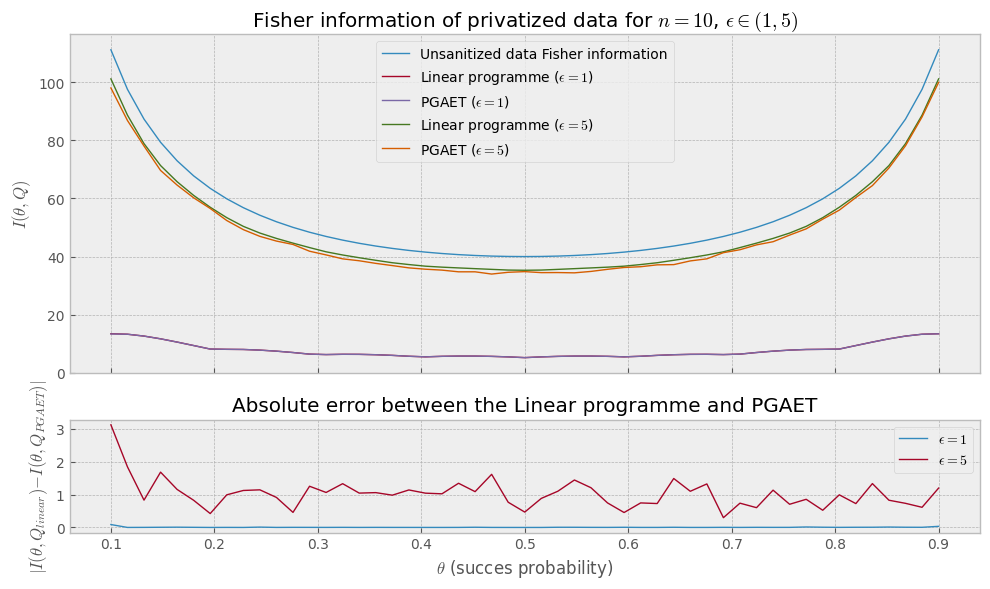

In [10]:
N = 10
EPSILON1 = 1
EPSILON2 = 5
LINEWIDTH = 1
lr = LinearSolver()
pg = PGAETMultipleRestarts(n_restarts=10)

thetas = np.linspace(1e-1, 1 - 1e-1, 51)

orig_fisher_infs = fisher_information_binom(N, thetas)

lr_fishers_high_priv = list()
lr_fisher_low_priv = list()
pg_fishers_high_priv = list()
pg_fishers_low_priv = list()
opt_qs_high_priv = list()
for theta in tqdm(thetas):
    _, _, _, fish = binom_optimal_privacy(
        lr, N, EPSILON1, theta
    )
    lr_fishers_high_priv.append(fish)
    _, _, _, fish = binom_optimal_privacy(
        lr, N, EPSILON2, theta
    )
    lr_fisher_low_priv.append(fish)

    _, _, _, fish = binom_optimal_privacy(
        pg, N, EPSILON1, theta
    )
    pg_fishers_high_priv.append(fish)
    q, _, _, fish = binom_optimal_privacy(
        pg, N, EPSILON2, theta
    )
    opt_qs_high_priv.append(q)
    pg_fishers_low_priv.append(fish)

fig, ax = plt.subplots(figsize=(10, 6), nrows=2, sharex=True, height_ratios=(3, 1))

ax[0].plot(thetas, orig_fisher_infs, label="Unsanitized data Fisher information", linewidth=LINEWIDTH)

ax[0].plot(thetas, lr_fishers_high_priv, label=rf"Linear programme ($\epsilon={EPSILON1}$)", linewidth=LINEWIDTH)
ax[0].plot(thetas, pg_fishers_high_priv, label=rf"PGAET ($\epsilon={EPSILON1}$)", linewidth=LINEWIDTH)

ax[0].plot(thetas, lr_fisher_low_priv, label=rf"Linear programme ($\epsilon={EPSILON2}$)", linewidth=LINEWIDTH)
ax[0].plot(thetas, pg_fishers_low_priv, label=rf"PGAET ($\epsilon={EPSILON2}$)", linewidth=LINEWIDTH)

ax[0].set_ylabel(r"$I(\theta, Q)$")
ax[0].set_title(
    rf"Fisher information of privatized data for $n={N}$, $\epsilon \in ({EPSILON1}, {EPSILON2})$"
)
ax[0].legend(fontsize="medium")

# error plot
ax[1].plot(thetas, np.array(lr_fishers_high_priv) - np.array(pg_fishers_high_priv), label=rf"$\epsilon={EPSILON1}$", linewidth=LINEWIDTH)
ax[1].plot(thetas, np.array(lr_fisher_low_priv) - np.array(pg_fishers_low_priv), label=rf"$\epsilon={EPSILON2}$", linewidth=LINEWIDTH)
ax[1].set_title("Absolute error between the Linear programme and PGAET")
ax[1].set_ylabel(r"$|I(\theta, Q_{linear})$" + r"$- I(\theta, Q_{PGAET})|$")
ax[1].set_xlabel(r"$\theta$ (succes probability)")
ax[1].legend(fontsize="medium")

plt.tight_layout()
plt.savefig("figures/n_10_low_and_high_eps")
plt.show()